In [416]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
sns.set(context='poster', style='white', font='Ubuntu')

all_train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [201]:
all_train['Breed'] = all_train['Breed'].str.replace('Black/Tan', 'BlackTan')
all_train['Breed'] = all_train['Breed'].str.replace('/Unknown', ' Unknown')
all_train['Breed'] = all_train['Breed'].str.replace('St. Bernard Rough Coat', 'StBernard')
all_train['Breed'] = all_train['Breed'].str.replace('St. Bernard Smooth Coat', 'StBernard')
all_train['Breed'] = all_train['Breed'].str.replace('German Shorthair Pointer', 'Pointer')
all_train['Breed'] = all_train['Breed'].str.replace('German Wirehaired Pointer', 'Pointer')
all_train['Breed'] = all_train['Breed'].str.replace('Dachshund Longhair', 'Dachshund')
all_train['Breed'] = all_train['Breed'].str.replace('Dachshund Wirehair', 'Dachshund')
all_train['Breed'] = all_train['Breed'].str.replace('English Pointer', 'Pointer')
all_train['Breed'] = all_train['Breed'].str.replace('Chihuahua Shorthair', 'Chihuahua')
all_train['Breed'] = all_train['Breed'].str.replace('Chihuahua Longhair', 'Chihuahua')
all_train['Breed'] = all_train['Breed'].str.replace('Alaskan Husky', 'Husky')
all_train['Breed'] = all_train['Breed'].str.replace('Siberian Husky', 'Husky')

all_train['Breed'] = all_train['Breed'].str.replace(' ', '')
all_train['Breed'] = all_train['Breed'].str.replace('PitBull', ' PitBull ')
all_train['Breed'] = all_train['Breed'].str.replace('Rottweiler', ' Rottweiler ')
all_train['Breed'] = all_train['Breed'].str.replace('/', ' known ')
all_train['Breed'] = all_train['Breed'].str.replace('Mix', ' Mix ')
#all_train['Breed'] = all_train['Breed'].str.replace('Mix', '')
all_train['Breed'] = all_train['Breed'].str.replace('Unknown', '')
all_train['Breed'] = all_train['Breed'].str.replace('Australian', '')
all_train['Breed'] = all_train['Breed'].str.replace('American', '')
all_train['Breed'] = all_train['Breed'].str.replace('German', '')
all_train['Breed'] = all_train['Breed'].str.replace('YorkshireTerrier', ' Yorkshire ')


def replaceBreed (s):
    if re.sub(' ','', s).lower() in [u'rhodridgeback', u'rottweiler', u'pekingese', u'labradorretriever', u'known', u'blacktanhound', 
     u'yorkshire', u'doguedebordeaux', u'bullterrier', u'englishcockerspaniel', u'colliesmooth', u'chihuahua', 
     u'cairnterrier', u'weimaraner', u'dutchshepherd', u'englishbulldog', u'englishfoxhound', u'greatpyrenees', 
     u'chinesesharpei', u'cockerspaniel', u'dobermanpinsch', u'staffordshireterrier', u'alaskanmalamute', u'mix', 
     u'entlebucher', u'shihtzu', u'goldenretriever', u'bluetickhound', u'irishsetter', u'vizsla', 
     u'italiangreyhound', u'cattledog', u'shepherd', u'toypoodle', u'bassethound', u'englishsetter', 
     u'ratterrier', u'lhasaapso', u'chowchow', u'bichonfrise', u'redbonehound', u'westhighland', 
     u'dogoargentino', u'bulldog', u'stbernard', u'boxer', u'softcoatedwheatenterrier', u'englishshepherd', 
     u'queenslandheeler', u'manchesterterrier', u'anatolshepherd', u'bostonterrier', u'dalmatian', u'kelpie', 
     u'pbgv', u'bloodhound', u'pug', u'plotthound', u'collierough', u'staffordshire', u'englishspringerspaniel', 
     u'dachshund', u'englishcoonhound', u'pitbull', u'husky', u'blackmouthcur',u'devonrex', 
     u'mainecoon', u'persian', u'japanesebobtail', u'bombay', u'javanese', u'bengal', u'mix',
     u'cymric', u'cornishrex', u'balinese', u'domesticshorthair', u'domesticmediumhair', u'turkishvan', 
    u'snowshoe', u'domesticlonghair', u'shorthair', u'known', u'angora', u'exoticshorthair', u'tonkinese', 
    u'manx', u'havanabrown', u'britishshorthair', u'burmese', u'himalayan', u'russianblue']:
        return s
    else:
        return 'others'
    
all_train['Breed'] = all_train['Breed'].map(replaceBreed)


In [467]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
dayOfWeek_alt={0:'Monday', 1:'TuesFri', 2:'TuesFri', 3:'TuesFri', 4:'TuesFri', 5:'SatSun', 6:'SatSun'}
MonthName={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep',10:'Oct',11:'Nov',12:'Dec'} 
MonthName_alt={1:'JanFeb', 2:'JanFeb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul',
               8:'Aug', 9:'SepNov',10:'SepNov',11:'SepNov',12:'Dec'}
timeOfDay = {5: 'Morning', 6: 'Morning', 7: 'Morning', 8: 'Morning', 9: 'Morning', 10: 'Morning', 11: 'Afternoon',
        12: 'Afternoon', 13: 'Afternoon', 14: 'Afternoon', 15: 'Afternoon', 16: 'Night', 17: 'Night', 18: 'Night',
        19: 'Night', 20: 'Night', 21: 'Night', 22: 'Night', 23: 'Night', 0: 'Midnight',}

def shortenBreed(s):
    s = s.lower()
    s = re.sub(' mix', '', s)
    s = re.sub('\\/.*', '', s)
    return s


def RecodeAges(s):
    more3_yr = ['13year','14year','15year','16year','17year','18year','19year','20year','3year','4year','5year','6year','7year','8year','9year','10year','11year','12year']
    lessone_yr = ['3month','4month','5month','6month','7month','8month','9month','10month','11month','0year']
    lessone_wk = ['1day','2day','3day','4day','5day','6day']
    lessone_mo = ['1week','1week','2week','3week','4week']
    oneortwo_mo = ['1month','5week','2month']
    oneortwo_yr = ['1year','2year']
    
    if isinstance(s, str):
        age = re.sub('[s, ]','', s)
    else:
        return 'UnknownAge'
    
    if age in more3_yr:
        return age
    elif age in lessone_yr:
        return '< 1yr'
    elif age in lessone_mo:
        return '< 1mo'
    elif age in oneortwo_mo:
        return '1 - 2 mos'
    elif age in oneortwo_yr:
        return '1 - 2 yrs'
    else:
        return '< 1wk'

def mixedBreed(s):
    if 'mix' in s.lower():
        return 1
    else:
        return 0

def process_data(df):
    df.ix[pd.isnull(df['Name']), 'Named'] = 'Unnamed'
    df.ix[pd.isnull(df['Named']), 'Named'] = 'Named'
    
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    df['weekday'] = df['DateTime'].dt.dayofweek.map(dayOfWeek_alt)
    df['month'] = df['DateTime'].dt.month.map(MonthName_alt)
    df['hour'] = df['DateTime'].dt.hour
    df['minute'] = df['DateTime'].dt.minute
    df['minutezero'] = (df['minute'] == 0).astype(int)
    df['ageGroups'] = df['AgeuponOutcome'].map(RecodeAges)
    df['mix'] = df['Breed'].map(mixedBreed)
    df['shortBreed'] = df['Breed'].map(shortenBreed)

    
    df['corp'] = df.apply(lambda x: ' '.join((x.Color, x.shortBreed, 
                                                       x.SexuponOutcome, x.Named, 
                                                       x.weekday, x.month)), axis=1)

    return df

all_train = process_data(all_train)



cv = CountVectorizer(min_df=0.05)
train_corpus = cv.fit_transform(all_train.corp)

def add_other_features(corpus, df, training=True):
    dense_corpus = pd.DataFrame(corpus.toarray(), columns = cv.get_feature_names())

    add = pd.concat([(df.AnimalType == 'Dog').astype(int), 
                     df.minutezero,
                     pd.get_dummies(df.hour),
                    pd.get_dummies(df.ageGroups)], axis=1)
    
    if training:
        add = pd.concat([add, df.OutcomeType], axis=1)
    return pd.concat([dense_corpus, add], axis=1)

new_corp = add_other_features(train_corpus, all_train)

split = new_corp.shape[0] // 20
dev = new_corp.iloc[:split,:-1]
train = new_corp.iloc[split:,:-1]

dev_labels = new_corp.iloc[:split,-1]
train_labels = new_corp.iloc[split:,-1]



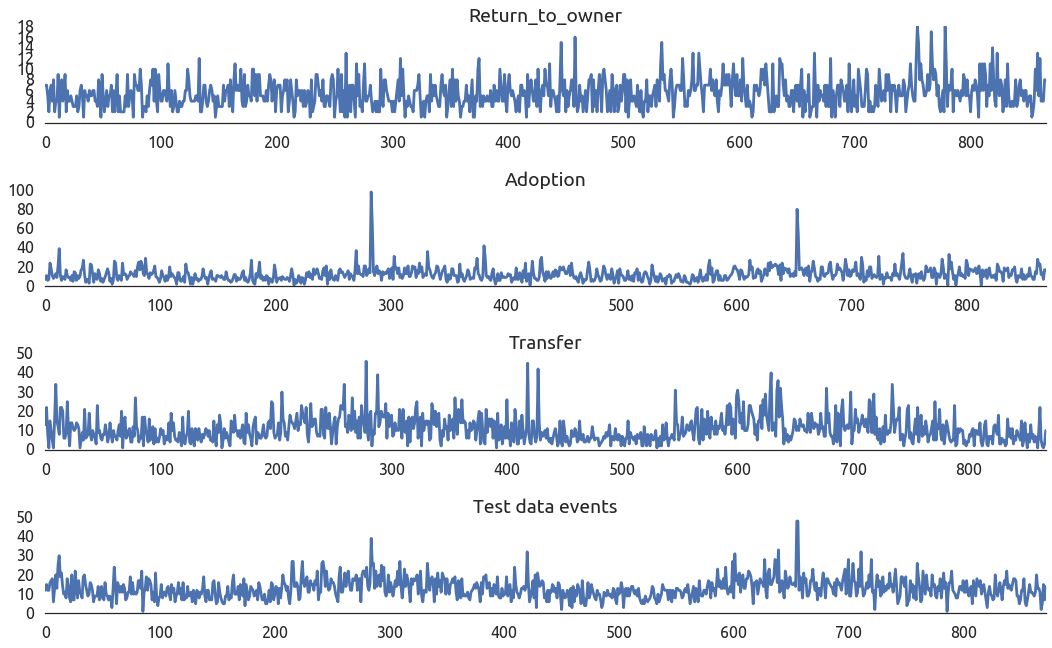

In [510]:
plt.figure(figsize=(15,9))
for i, outcome in enumerate(['Return_to_owner','Adoption','Transfer']):
    d = all_train[all_train.OutcomeType == outcome]
    plt.subplot(4,1,i+1)
    sns.tsplot(d.groupby([d.DateTime.dt.normalize()]).count()['AnimalID'])
    plt.title(outcome)
    plt.tight_layout()
    sns.despine(left=True)
    
plt.subplot(4,1,4)
sns.tsplot(test.groupby([test.DateTime.dt.normalize()]).count()['ID'])
plt.title('Test data events')
sns.despine(left=True)


In [512]:
for i, outcome in enumerate(['Adoption','Transfer']):
    d = all_train[all_train.OutcomeType == outcome]
    dg = d.groupby([d.DateTime.dt.normalize()]).count()['AnimalID'].sort_values(ascending=False)
    print dg[:2]

DateTime
2014-07-12    98
2015-07-18    80
Name: AnimalID, dtype: int64
DateTime
2014-07-08    46
2014-11-25    45
Name: AnimalID, dtype: int64


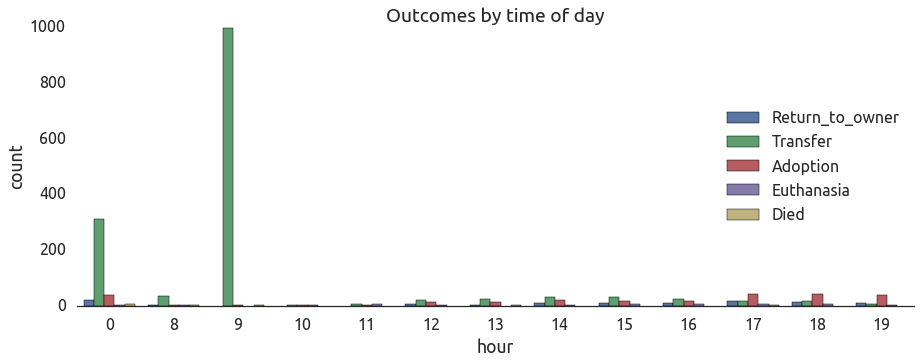

In [412]:
plt.figure(figsize=(15,5))
plt.title('Outcomes by time of day')

sns.countplot(x='hour', hue='OutcomeType', data=all_train[all_train['minutezero'] == 1])
plt.legend(loc='right')

sns.despine(left=True)

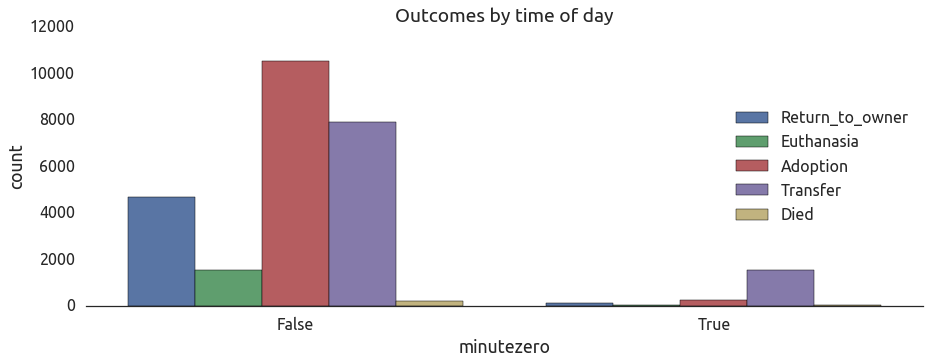

In [396]:
plt.figure(figsize=(15,5))
plt.title('Outcomes by time of day')

sns.countplot(x='minutezero', hue='OutcomeType', data=all_train)
plt.legend(loc='right')


sns.despine(left=True)

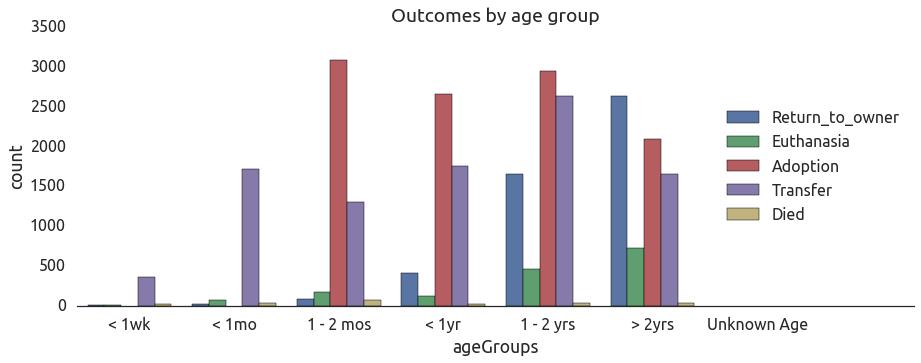

In [377]:
plt.figure(figsize=(15,5))
plt.title('Outcomes by age group')

sns.countplot(x='ageGroups', hue='OutcomeType', data=all_train, 
              order=['< 1wk','< 1mo','1 - 2 mos', '< 1yr','1 - 2 yrs','> 2yrs','Unknown Age',' '])
plt.legend(loc='right')

sns.despine(left=True)

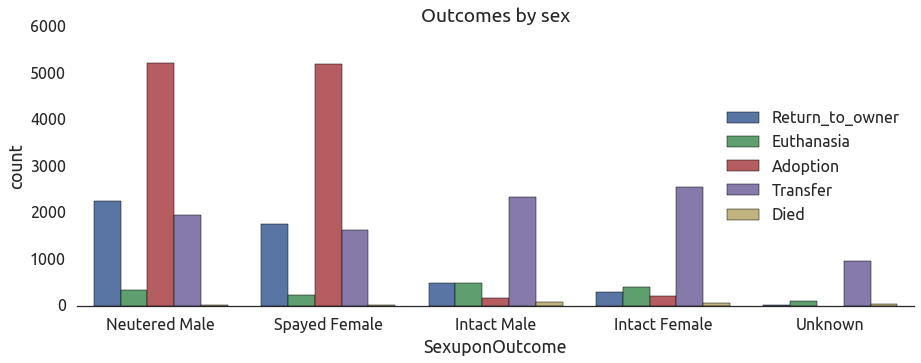

In [378]:
plt.figure(figsize=(15,5))
plt.title('Outcomes by sex')

sns.countplot(x='SexuponOutcome', hue='OutcomeType', data=all_train)
plt.legend(loc='right')

sns.despine(left=True)

Logistic Regression Log Loss: 0.972
Logistic Regression Accuracy: 0.579


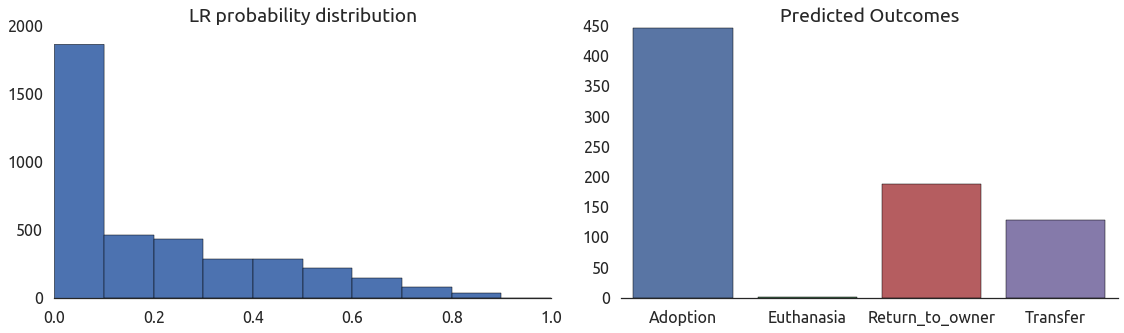

In [472]:
clf = LogisticRegression(penalty='l1', C=0.1)
clf.fit(train[train['AnimalType'] == 1], train_labels[train['AnimalType'] == 1])
probs = clf.predict_proba(dev[dev['AnimalType'] == 1])
preds = clf.predict(dev[dev['AnimalType'] == 1])
print 'Logistic Regression Log Loss: {:.3f}'.format(log_loss(dev_labels[dev['AnimalType'] == 1], probs))
print 'Logistic Regression Accuracy: {:.3f}'.format(clf.score(dev[dev['AnimalType'] == 1], dev_labels[dev['AnimalType'] == 1]))

plt.figure(figsize=(16,5)) 
# plt.subplot(1,2,1)
# sns.barplot(, orient="h", palette='Blues_d')
# plt.title('Feature Weights')

plt.subplot(1,2,1)
plt.hist(probs.ravel(), range=[0,1])
plt.title('LR probability distribution')

plt.subplot(1,2,2)
sns.barplot(np.unique(preds, return_counts=True)[0], np.unique(preds, return_counts=True)[1])
plt.title('Predicted Outcomes')


# clf = RandomForestClassifier(n_estimators=1000, n_jobs=-1, criterion='entropy')
# clf.fit(train, train_labels)
# preds = clf.predict_proba(dev)
# print 'RF Log Loss: {:.3f}'.format(log_loss(dev_labels, preds, eps=0.1))
# print 'RF Accuracy: {:.3f}'.format(clf.score(dev, dev_labels))

# plt.subplot(2,2,4)
# plt.hist(preds.ravel(), range=[0,1])
# plt.title('RF probability distribution')

plt.tight_layout()
sns.despine(left=True)

[[264   0   0  43  12]
 [  0   0   0   0   1]
 [ 17   0   2  15   9]
 [109   0   0  89  17]
 [ 61   0   0  42  89]]


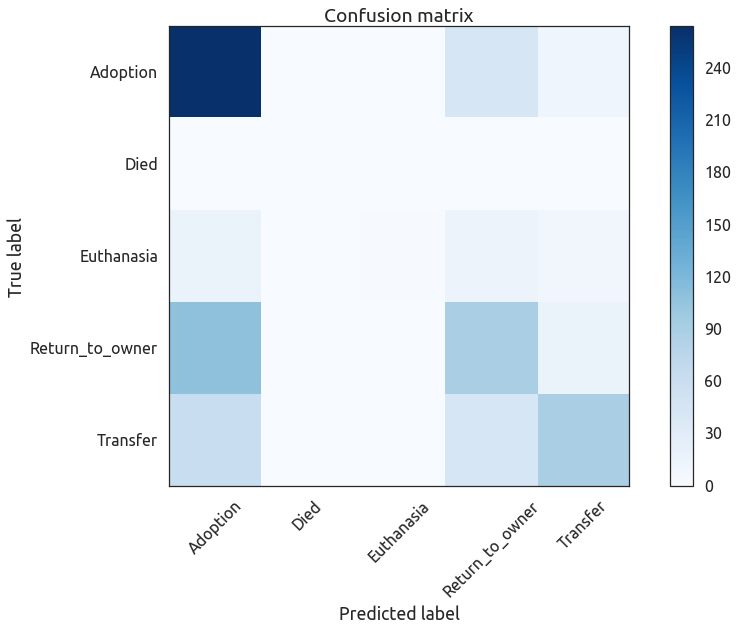

In [446]:
# print clf.classes_
cm = confusion_matrix(dev_labels[dev['AnimalType'] == 1], preds, labels=clf.classes_)


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=clf.classes_):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm


In [464]:
all_train[:split][dev['AnimalType'] == 1][(dev_labels[dev['AnimalType'] == 1] == 'Return_to_owner') & (preds == 'Adoption')]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Named,weekday,month,hour,minute,minutezero,ageGroups,corp
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Named,TuesFri,JanFeb,18,22,0,1 - 2 yrs,Brown/White Shetland Sheepdog Mix Neutered Mal...
13,A704702,Scooter,2015-06-08 16:30:00,Return_to_owner,NaN,Dog,Neutered Male,2 years,Yorkshire Terrier Mix,Black/Red,Named,Monday,Jun,16,30,0,1 - 2 yrs,Black/Red Yorkshire Terrier Mix Neutered Male ...
14,A688584,Preston,2015-11-25 15:00:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Great Pyrenees Mix,White/Cream,Named,TuesFri,SepNov,15,0,1,1 - 2 yrs,White/Cream Great Pyrenees Mix Neutered Male N...
19,A684787,Kuma,2014-07-30 17:34:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Flat Coat Retriever Mix,Black,Named,TuesFri,Jul,17,34,0,1 - 2 yrs,Black Flat Coat Retriever Mix Neutered Male Na...
24,A676333,Trigger,2014-04-09 17:44:00,Return_to_owner,NaN,Dog,Neutered Male,2 months,German Shepherd Mix,Black/Brown,Named,TuesFri,Apr,17,44,0,1 - 2 mos,Black/Brown German Shepherd Mix Neutered Male ...
74,A669540,Snookie,2013-12-28 16:17:00,Return_to_owner,NaN,Dog,Spayed Female,4 years,Yorkshire Terrier Mix,Blue/Tan,Named,SatSun,Dec,16,17,0,4year,Blue/Tan Yorkshire Terrier Mix Spayed Female N...
107,A668362,Minnie,2013-12-20 12:02:00,Return_to_owner,NaN,Dog,Spayed Female,2 years,Chihuahua Shorthair Mix,Black/Tan,Named,TuesFri,Dec,12,2,0,1 - 2 yrs,Black/Tan Chihuahua Shorthair Mix Spayed Femal...
119,A701428,Kiki,2015-05-03 16:59:00,Return_to_owner,NaN,Dog,Spayed Female,3 years,Chihuahua Shorthair Mix,Brown,Named,SatSun,May,16,59,0,3year,Brown Chihuahua Shorthair Mix Spayed Female Na...
128,A699094,Levon,2015-03-22 18:40:00,Return_to_owner,NaN,Dog,Neutered Male,2 years,Chihuahua Shorthair Mix,Brown/White,Named,SatSun,Mar,18,40,0,1 - 2 yrs,Brown/White Chihuahua Shorthair Mix Neutered M...
134,A696350,Minnie,2015-12-15 17:30:00,Return_to_owner,NaN,Dog,Spayed Female,1 year,Pit Bull,Brown Brindle,Named,TuesFri,Dec,17,30,0,1 - 2 yrs,Brown Brindle Pit Bull Spayed Female Named Tue...


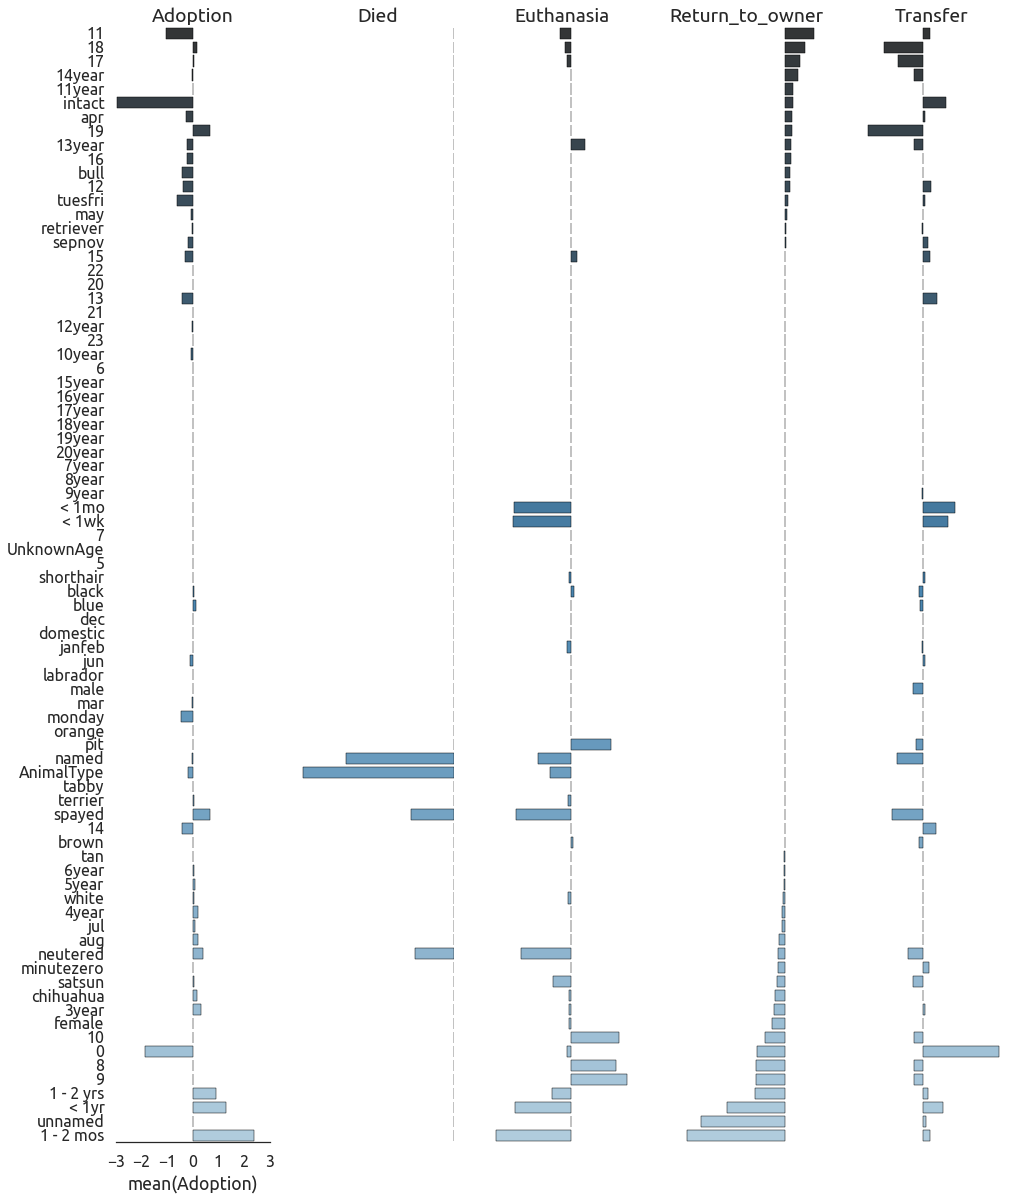

In [473]:

feat_import = pd.DataFrame(clf.coef_, 
                           columns=train.columns, 
                           index=clf.classes_).T.sort_values('Return_to_owner', ascending=False)


plt.figure(figsize=(16,20)) 

for i, j in enumerate(feat_import.columns):
    plt.subplot(1,5,i + 1)
    sns.barplot(x=feat_import.loc[:,j], y=feat_import.index, orient="h", palette='Blues_d')
    plt.title(j)
    if i > 0:
        plt.axis('off')
        
sns.despine(left=True)

In [433]:
clf.fit(new_corp.iloc[:,:-1], new_corp.iloc[:,-1])

test = process_data(test)
test_corpus = cv.transform(test.corp)

new_test = add_other_features(test_corpus, test, training=False)

preds = clf.predict_proba(new_test)

for i, outcome in enumerate(clf.classes_):
    test[outcome] = preds[:,i]
    
test['prediction'] = clf.predict(new_test)

In [172]:
submission = test[['ID','Adoption','Died','Euthanasia','Return_to_owner','Transfer']]
submission.to_csv('submission.csv', index=False)